## Loading all the needed packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/JordanFoss/STAT3007_Project.git
%cd STAT3007_Project/
pip install colorednoise
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import scipy
import numpy as np
import librosa
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable
import pandas as pd
import glob
from librosa import display

from IPython.display import Audio

# load our own python files
from pre_process import *
from data_loading import *
from CNN_Model import *

## Load Clean Data (run only this cell for clean data training and testing)

In [ ]:
#Load the clean audio data
X,y = load_samples('/content/STAT3007_Project', padding = True, truncating = True, normal = True, duration = 2, Noisfy=False)
X = np.array(X)
# (batch_size, channels, freq, time)
X = X.reshape(X.shape[0],1,X.shape[1],X.shape[2])
X = torch.tensor(X)
y = torch.tensor(y)

data_train, data_test = load_sets(X,y)[0]

## Load All Noisy Data (run only this cell for noisy data training and testing)

In [ ]:
#Import all the noisy data
noisy_data_train = np.load('/content/drive/MyDrive/STAT3007 project/train_test_split_snr40/noisy_train_snr40.npy')
noisy_data_test = np.load('/content/drive/MyDrive/STAT3007 project/train_test_split_snr40/noisy_test_snr40.npy')
noisy_targets_train = np.load('/content/drive/MyDrive/STAT3007 project/train_test_split_snr40/target_train_snr40.npy')
noisy_targets_test = np.load('/content/drive/MyDrive/STAT3007 project/train_test_split_snr40/target_test_snr40.npy')

noisy_data_train = noisy_data_train.reshape(noisy_data_train.shape[0],1,noisy_data_train.shape[1],noisy_data_train.shape[2])
noisy_data_test = noisy_data_test.reshape(noisy_data_test.shape[0],1,noisy_data_test.shape[1],noisy_data_test.shape[2])

noisy_data_train = torch.tensor(noisy_data_train)
noisy_data_test = torch.tensor(noisy_data_test)
noisy_targets_train = torch.tensor(noisy_targets_train)
noisy_targets_test = torch.tensor(noisy_targets_test)

wrapper_train = DatasetWrapper(noisy_data_train, noisy_targets_train)
wrapper_test = DatasetWrapper(noisy_data_test, noisy_targets_test)
data_train, data_test = wrapper_train, wrapper_test

# Training and Testing

In [ ]:
loss = nn.CrossEntropyLoss()
nepoch = 50
batch_size = 10
torch.manual_seed(69)
CNN = ConvNet_RGB(contain_linear = True, filter_num = 8, channels = 3)
trained_net, avg_loss, avg_acc, test_loss, test_acc = train_model(data_train,data_test, CNN, loss, nepoch = nepoch,lr = 0.001, batch_size = batch_size, use_cuda = True,print_output = False, momentum=0.4)
X_test, y_test = data_test.get_data()
X_test = X_test.type(torch.FloatTensor).to(torch.device('cpu'))
trained_net = trained_net.to(torch.device('cpu'))
y_pred = trained_net(X_test)
accuracy_score = accuracy(y_pred,y_test)
print('accuracy:' + str(accuracy_score))

accuracy:0.43953487277030945


In [ ]:
import sklearn
labels = ['Calm', 'Happy', 'Sad', 'Angry', 'Suprised']
confusion = sklearn.metrics.confusion_matrix(y_test, torch.argmax(y_pred, dim=1))
thing = sklearn.metrics.ConfusionMatrixDisplay(confusion, display_labels=labels)
thing.plot(values_format='.5g')

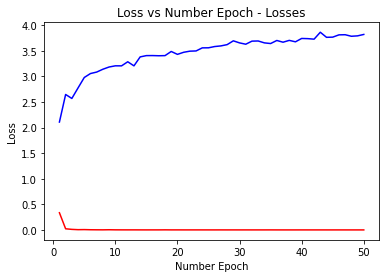

In [ ]:
plt.plot([x for x in range(1,nepoch+1)], avg_loss, 'r', [x for x in range(1,nepoch+1)], test_loss, 'b')
plt.xlabel("Number Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Number Epoch - Losses")
plt.show()
plt.plot([x for x in range(1,nepoch+1)], avg_acc, 'r', [x for x in range(1,nepoch+1)], test_acc, 'b')
plt.xlabel("Number Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number Epoch - Accuracy")
plt.show()